## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, dependencies and functions

In [24]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#%matplotlib qt
%matplotlib inline


def cal_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx=9
    ny=6
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    images_ret=[]

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
        if ret == True:
            images_ret.append(fname)
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            image_name=fname.split("/",1)[1]
            plt.imsave("camera_cal_output/draw_"+image_name,img)
            #cv2.waitKey(500)
    print("Done - draw on cal image")

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print("Done - got parameters")

    for fname in images_ret:
        img = mpimg.imread(fname)
        dst = undistort_image(img,mtx,dist)
        image_name=fname.split("/",1)[1]
        plt.imsave("camera_cal_output/undistort_"+image_name,dst)
    
    print("Done - undistort cal image")
    print("Finish Camera Calibration!")
    return mtx, dist

def undistort_image(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def r_select(img, thresh=(200, 255)):
    R = img[:,:,0]
    binary_img = np.zeros_like(R)
    binary_img[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_img

#gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, sobel_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_thresh(img, hls_which=1,thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,hls_which]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combined_binary(img,ksize=3,hls_which=1, s_thresh=(190, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    combined_img = np.zeros_like(s_binary)
    combined_img[(s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return combined_img,s_binary,sxbinary

def combined_binary2(img, ksize=3,hls_which=1, s_thresh=(100, 255),sx_thresh=(20, 100)):
    
    #abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, sobel_thresh=(30, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, sobel_thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.2, np.pi/2))
    hls_binary=hls_thresh(img,hls_which, s_thresh)
    sxbinary = np.zeros_like(hls_binary)
    sxbinary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))|(hls_binary==1)] = 1
    return combined_img,hls_binary,sxbinary

def combined_binary3(img, ksize=3,hls_which=1,s_thresh=(100, 255), sx_thresh=(20, 100)):
    
    #abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize,sobel_thresh=(20, 160))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, sobel_thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(80, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.8, 1.8))
    hls_binary=hls_thresh(img,hls_which, s_thresh)
    combined_img = np.zeros_like(hls_binary)
    combined_img[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))|(hls_binary==1)] = 1
    return combined_img,hls_binary,gradx

def combined_binary4(img, ksize=3,hls_which=1,s_thresh=(100, 255), sx_thresh=(20, 100)):
    
    #abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize,sobel_thresh=(30, 100))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, sobel_thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    r_binary=r_select(img, thresh=(200, 255))
    combined_img = np.zeros_like(r_binary)
    combined_img[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))|(r_binary==1)] = 1
    return combined_img,r_binary,gradx
              
              
def warp_image(img,src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv= cv2.getPerspectiveTransform(dst,src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped,M,Minv

def mask_image(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

    
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    
    # or just use the single line below
    #histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

def find_lane_pixels(binary_warped, nwindows = 9, margin = 100,  minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

  

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
                
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty,out_img


def fit_polynomial(leftx, lefty, rightx, righty):
   
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit


def fit_poly(warped_img,left_fit,right_fit):
    
    img_shape=warped_img.shape
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    Max_y=np.max(ploty)
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    
    left_btm_x = left_fit[0]*Max_y**2 + left_fit[1]*Max_y + left_fit[2]
    right_btm_x = right_fit[0]*Max_y**2 + right_fit[1]*Max_y + right_fit[2]
    left_top_x = left_fit[2]
    right_top_x = right_fit[2]
    
    
    return left_fitx, right_fitx, ploty,left_btm_x,right_btm_x,left_top_x,right_top_x

def search_around_poly(binary_warped,left_fit, right_fit,nwindows = 9, margin = 100,  minpix = 50):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img




def fill_lane(undist_img,warped_img,Minv,ploty,left_fitx,right_fitx):       
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result

def measure_curvature_pixels(left_fit, right_fit,ploty,ym_per_pix,xm_per_pix):
    
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval=np.max(ploty)
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    lane_center = (left_lane_bottom + right_lane_bottom)/2
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    return left_curverad, right_curverad,center, left_lane_bottom,right_lane_bottom



class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # need to reset by using full scan
        self.need_reset=False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        self.recent_topxfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.best_topx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.recent_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  


def process_image(image):
    
    global mtx,dist,vertices,src,dst,i_frame,ym_per_pix,xm_per_pix,left_line,right_line,lane_width
    global middle,halfwidth,line_reset,finding_method, result_file
    undist_img=undistort_image(image,mtx,dist)
    binary_img,s_binary,sxbinary=combined_binary(undist_img,3,hls_which=2,s_thresh=(180, 255), sx_thresh=(30, 100))
    #binary_img=combined_binary3(undist_img, 3, (20, 100))
    masked_img=mask_image(binary_img,vertices)
    warped_img,M,Minv=warp_image(masked_img,src, dst)
    
    result_file.write("\n\nframe# %d\n" % i_frame)
    
    if i_frame==0 or left_line.need_reset==True or right_line.need_reset==True :
        leftx, lefty, rightx, righty, find_poly_img=find_lane_pixels(warped_img,nwindows = 9, margin = 50,  minpix = 40)
        finding_method=0
        if i_frame>0:
            leftx1, lefty1, rightx1, righty1,find_poly_img=search_around_poly(warped_img,left_line.recent_fit[-1],right_line.recent_fit[-1],nwindows = 9, margin = 60,  minpix = 40)    
            left_fit1,right_fit1=fit_polynomial(leftx1, lefty1, rightx1, righty1)
            left_fitx1, right_fitx1, ploty1,left_btm_x1,right_btm_x1,left_top_x1,right_top_x1=fit_poly(warped_img,left_fit1,right_fit1)
    else:
        leftx, lefty, rightx, righty,find_poly_img=search_around_poly(warped_img,left_line.recent_fit[-1],right_line.recent_fit[-1],nwindows = 9, margin = 60,  minpix = 40)    
        finding_method=1

    left_fit,right_fit=fit_polynomial(leftx, lefty, rightx, righty)
    left_fitx, right_fitx, ploty,left_btm_x,right_btm_x,left_top_x,right_top_x=fit_poly(warped_img,left_fit,right_fit)
    result_file.write("original left_fit " + str(left_fit)+"\n")
    result_file.write("original right_fit "+ str(right_fit)+"\n")

    if i_frame==0:
            left_line=Line()
            right_line=Line()
            left_line.detected=True
            right_line.detected=True
            left_line.recent_xfitted.append(left_btm_x)
            right_line.recent_xfitted.append(right_btm_x)
            left_line.bestx=left_btm_x
            right_line.bestx=right_btm_x
            left_line.recent_topxfitted.append(left_top_x)
            right_line.recent_topxfitted.append(right_top_x)
            left_line.best_topx=left_top_x
            right_line.best_topx=right_top_x
            left_line.recent_fit.append(left_fit)
            right_line.recent_fit.append(right_fit)
            left_line.best_fit=list(left_fit)
            right_line.best_fit=list(right_fit)
            left_line.diffs=[0,0,0]
            right_line.diffs=[0,0,0]


    if i_frame>0 :

       
        # find out if the line was detected or not
       
        left_curverad, right_curverad,center,left_lane_bottom,right_lane_bottom=measure_curvature_pixels(left_fit, right_fit,ploty,ym_per_pix,xm_per_pix)
        result_file.write("original left_curverad " + str(left_curverad)+"\n")
        result_file.write("original right_curverad "+ str(right_curverad)+"\n")
        
        '''
        if left_curverad>left_line.radius_of_curvature*0.85 and left_curverad<left_line.radius_of_curvature*1.15 \
            and abs(left_btm_x-left_line.bestx)<40 and abs(left_top_x-left_line.best_topx)<40:
            
            left_line.detected=True
            left_line.need_reset=False
            result_file.write("left0\n")
        elif left_curverad<left_line.radius_of_curvature*0.5 or left_curverad>left_line.radius_of_curvature*2 \
            and abs(left_btm_x-left_line.bestx)>100 or abs(left_top_x-left_line.best_topx)>100:
            
            left_line.detected=False
            left_line.need_reset=True

            if finding_method==0:
                for i in range(3):
                    left_fit[i]=left_line.best_fit[i]*0.9+left_fit1[i]*0.1
                result_file.write("left1\n")
            else:
                for i in range(3):
                    left_fit[i]=left_line.best_fit[i]*0.9+left_fit[i]*0.1
                result_file.write("left2\n")
        else:
            for i in range(3):
                left_fit[i]=left_line.best_fit[i]*0.6+left_fit[i]*0.4
            left_line.detected=False
            left_line.need_reset=True
            result_file.write("left3\n")
            
            
        '''    
        if left_curverad>left_line.radius_of_curvature*0.75 and left_curverad<left_line.radius_of_curvature*1.25:
            left_line.detected=True
            left_line.need_reset=False
        elif left_curverad<left_line.radius_of_curvature*0.50 or left_curverad>left_line.radius_of_curvature*1.50:
            for i in range(3):
                left_fit[i]=left_line.recent_fit[-1][i]*0.8+left_fit[i]*0.2
            left_line.detected=False
            left_line.need_reset=False
        else:
            for i in range(3):
                left_fit[i]=left_line.recent_fit[-1][i]*0.5+left_fit[i]*0.5
            left_line.detected=False
            left_line.need_reset=True    
       
            
        if right_curverad>right_line.radius_of_curvature*0.85 and right_curverad<right_line.radius_of_curvature*1.15 \
            and abs(right_btm_x-right_line.bestx)<30 and abs(right_top_x-right_line.best_topx)<30:
            
            right_line.detected=True
            right_line.need_reset=False
            result_file.write("right0\n")
        elif right_curverad<right_line.radius_of_curvature*0.5 or right_curverad>right_line.radius_of_curvature*2 \
            and abs(right_btm_x-right_line.bestx)>80 or abs(right_top_x-right_line.best_topx)>80:
            
            right_line.detected=False
            right_line.need_reset=True

            if finding_method==0:
                for i in range(3):
                    right_fit[i]=right_line.best_fit[i]*0.9+right_fit1[i]*0.1
                result_file.write("right1\n")
            else:
                for i in range(3):
                    right_fit[i]=right_line.best_fit[i]*0.9+right_fit[i]*0.1
                result_file.write("right2\n")
        else:
            for i in range(3):
                right_fit[i]=right_line.best_fit[i]*0.8+right_fit[i]*0.2
            right_line.detected=False
            right_line.need_reset=True
            result_file.write("right3\n")

                
        result_file.write("left_line.detected  " + str(left_line.detected)+"\n")
        result_file.write("right_line.detected " + str(right_line.detected)+"\n")        
        result_file.write("Adjusted left_fit " + str(left_fit)+"\n")
        result_file.write("Adjusted right_fit "+ str(right_fit)+"\n")
        result_file.write("Left_line.need_reset " + str(left_line.need_reset)+"\n")
        result_file.write("Right_line.need_reset "+ str(right_line.need_reset)+"\n")
        #update date based on new cofficient
        left_fitx, right_fitx, ploty,left_btm_x,right_btm_x,left_top_x,right_top_x=fit_poly(warped_img,left_fit,right_fit)
        #update the line object.
        left_line.recent_xfitted.append(left_btm_x)
        right_line.recent_xfitted.append(right_btm_x)
        if len(left_line.recent_xfitted)>5 :
                left_line.recent_xfitted.pop(0)
                right_line.recent_xfitted.pop(0)
        left_line.bestx=sum(left_line.recent_xfitted)/len(left_line.recent_xfitted)
        right_line.bestx=sum(right_line.recent_xfitted)/len(right_line.recent_xfitted)

        left_line.recent_topxfitted.append(left_top_x)
        right_line.recent_topxfitted.append(right_top_x)
        if len(left_line.recent_topxfitted)>5 :
            left_line.recent_topxfitted.pop(0)
            right_line.recent_topxfitted.pop(0)
        left_line.best_topx=sum(left_line.recent_topxfitted)/len(left_line.recent_topxfitted)
        right_line.best_topx=sum(right_line.recent_topxfitted)/len(right_line.recent_topxfitted)
       
 
        left_line.recent_fit.append(left_fit)
        right_line.recent_fit.append(right_fit)
        if len(left_line.recent_fit)>5 :
            left_line.recent_fit.pop(0)
            right_line.recent_fit.pop(0)
  
        for i in range(3):
            left_line.best_fit[i]=sum(subl[i] for subl in left_line.recent_fit)/len(left_line.recent_fit)
            right_line.best_fit[i]=sum(subl[i] for subl in right_line.recent_fit)/len(right_line.recent_fit)  

    left_curverad, right_curverad,center,left_lane_bottom,right_lane_bottom=measure_curvature_pixels(left_fit, right_fit,ploty,ym_per_pix,xm_per_pix)
    result_file.write("len(left_line.recent_fit) %d \n" % len(left_line.recent_fit))
    result_file.write("len(right_line.recent_fit) %d \n" % len(right_line.recent_fit))
    result_file.write("left_line.recent_fit " + str(left_line.recent_fit)+"\n")
    result_file.write("right_line.recent_fit " + str(right_line.recent_fit)+"\n")
    result_file.write("left_line.best_fit " + str(left_line.best_fit)+"\n")
    result_file.write("right_line.best_fit " + str(right_line.best_fit)+"\n")
    result_file.write("Adjusted left_curverad " + str(left_curverad)+"\n")
    result_file.write("Adjusted right_curverad "+ str(right_curverad)+"\n")
    result_file.write("center " + str(center)+"\n")
    result_file.write("left_lane_bottom " + str(left_lane_bottom)+"\n")
    result_file.write("right_lane_bottom "+ str(right_lane_bottom)+"\n")
    
    left_line.radius_of_curvature=left_curverad
    right_line.radius_of_curvature=right_curverad
    left_line.line_base_pos=lane_width/2+center
    right_line.line_base_pos=lane_width/2-center 
    left_line.allx=list(left_fitx)
    left_line.ally=list(ploty)
    right_line.allx=list(right_fitx)
    right_line.ally=list(ploty)
    
    
    filled_img=fill_lane(undist_img, warped_img,Minv,ploty,left_line.allx,right_line.allx)
    warped3_img = np.dstack((warped_img, warped_img, warped_img)) * 255
    text1_on_img="Radius of Curvature: {:.2f}m".format(left_line.radius_of_curvature)
    LorR = "left" if center < 0 else "right"
    text2_on_img="Car is {:.2f}m {} of the center.".format(abs(center),LorR)
    
    process_img=filled_img
    cv2.putText(process_img,text1_on_img,(300,40), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(process_img,text2_on_img,(300,80), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(process_img,"frame#"+str(i_frame),(40,640), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 1, cv2.LINE_AA)
    
    i_frame+=1
    #cv2.line(process_img, (140,720), (560,440), [0, 0, 255], 2)
    #cv2.line(process_img, (560,440), (740,440), [0, 0, 255], 2)
    #cv2.line(process_img, (740,440), (1260,720), [0, 0, 255], 2)
    return process_img


###  Camera Calibration

In [13]:
print("starting calibration camera....please wait")
mtx, dist=cal_camera()

print("pickle to data file")
output = open('camera_cal_data.pkl', 'wb')
pickle.dump(mtx, output)
pickle.dump(dist, output)
output.close()



starting calibration camera....please wait
Done - draw on cal image
Done - got parameters
Done - undistort cal image
Finish Camera Calibration!
pickle to data file


### Initialization

In [3]:

# set up public variables
src = np.float32([[600,450], [215,720],[680,450],[1100,720]])
middle=640
halfwidth=200
dst = np.float32([[middle-halfwidth,0], [middle-halfwidth,720],[middle+halfwidth,0], [middle+halfwidth,720]])
lane_width=3.7
ym_per_pix = 150/720 # meters per pixel in y dimension
xm_per_pix = lane_width/400 # meters per pixel in x dimension
#mask_list=[[140,720], [560,440],[710,440], [1180,720]] #mask for test image
mask_list=[[140,720], [560,440],[740,440], [1260,720]] #mask for video
vertices=np.array(mask_list)
line_reset=True
finding_method=0
offset = 100
img_size = (1280,720) # (shape[1] width 1280,shape[0] height 720)

#unpickle mtx and dist
pkl_file = open('camera_cal_data.pkl', 'rb')
mtx = pickle.load(pkl_file)
dist = pickle.load(pkl_file)
pkl_file.close()

### pipeline for test images

In [29]:
print("Start processing test images \n")
images = glob.glob('test_images/*.jpg')

result_file= open("test_image_result.txt","w+")
for fname in images:
    img = mpimg.imread(fname)
    i_frame=0
    left_line=Line() 
    right_line=Line()
    process_img= process_image(img)
    image_name=fname.split("/",1)[1]
    plt.imsave("test_images_output/Filled_"+image_name,process_img)
    print(fname, "----finished and saved ")
print("\nFinished processing test image")
result_file.close()



Start processing test images 

test_images/straight_lines1.jpg ----finished and saved 
test_images/test2.jpg ----finished and saved 
test_images/straight_lines2.jpg ----finished and saved 
test_images/test4.jpg ----finished and saved 
test_images/test1.jpg ----finished and saved 
test_images/test6.jpg ----finished and saved 
test_images/test5.jpg ----finished and saved 
test_images/test3.jpg ----finished and saved 

Finished processing test image


### pipeline for video

In [27]:
project_video_output = 'test_videos_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

i_frame=0
left_line=Line() 
right_line=Line()
result_file= open("video_result.txt","w+")
clip1 = VideoFileClip("test_videos/project_video.mp4")#.subclip(0,30)
project_video_clip = clip1.fl_image(process_image)  #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
result_file.close()


[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:40<00:00,  4.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 2min 8s, sys: 19.3 s, total: 2min 28s
Wall time: 4min 43s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))



##  Code for debugging and create images for writeup

Start processing test images 

Finished 



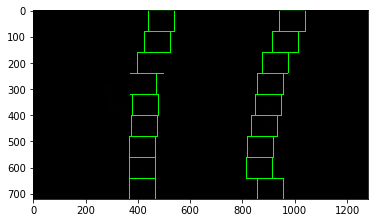

In [17]:


def process_image_1(image):
    
    global mtx,dist,vertices,src,dst,i_frame,ym_per_pix,xm_per_pix,left_line,right_line,lane_width
    global middle,halfwidth,line_reset,result_file
    undist_img=undistort_image(image,mtx,dist)
    binary_img,s_binary,sxbinary=combined_binary(undist_img,3,hls_which=2,s_thresh=(180, 255), sx_thresh=(30, 100))
    #binary_img,s_binary,sxbinary=combined_binary3(undist_img,3,hls_which=2,s_thresh=(180, 255), sx_thresh=(5, 220))
    masked_img=mask_image(binary_img,vertices)
    warped_img,M,Minv=warp_image(masked_img,src, dst)
    leftx, lefty, rightx, righty, find_poly_img=find_lane_pixels(warped_img,nwindows = 9, margin =50,  minpix = 40)
    left_fit,right_fit=fit_polynomial(leftx, lefty, rightx, righty)
    left_fitx, right_fitx, ploty,left_btm_x,right_btm_x,left_top_x,right_top_x=fit_poly(warped_img,left_fit,right_fit)
    filled_img=fill_lane(undist_img, warped_img,Minv,ploty,left_line.allx,right_line.allx)
    
    return  undist_img,binary_img,s_binary,sxbinary, masked_img,warped_img,find_poly_img #,left_btm_x,left_top_x

print("Start processing test images \n")
#fname="video_frame/Frame_0025.jpg"
fname="test_images/test5.jpg"
img = mpimg.imread(fname)
undist_img,binary_img,s_binary,sxbinary, masked_img,warped_img,find_poly_img= process_image_1(img)
#plt.imshow(out_img)
#plt.imshow(warped_img)
image_name=fname.split("/",1)[1]
#plt.imsave("test_images_output/undist__"+image_name,undist_img)
#plt.imsave("test_images_output/binary_"+image_name,binary_img)
#plt.imsave("test_images_output/s_binary_"+image_name,s_binary)
#plt.imsave("test_images_output/sxbinary_"+image_name,sxbinary)
#plt.imsave("test_images_output/masked_"+image_name,masked_img)
#plt.imsave("test_images_output/warped_"+image_name,warped_img)
#plt.imsave("test_images_output/find_lane_pixels_img_"+image_name,find_lane_pixels_img)
plt.imshow(find_poly_img)
print("Finished \n")

